# 数据预处理
- 异常值检测
- 数据归一化处理
- 除去相关度低的attribute
- 除去方差小的属性
- （最后手段）利用主成分分析进行数据降维

# 随机森林实现

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn import ensemble # ensemble learning: 集成学习
from sklearn import preprocessing
import sklearn.tree as tree
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('./OnlineNewsPopularity/OnlineNewsPopularity.csv') 
# df.head()
# print('shares: ', Counter(df[' shares']>1400))   # True 19562; False 20082
# print(df[' shares'])
y = (df[' shares']>1400)*1
X = preprocessing.scale(df.iloc[:, 2:-1])   # 数据归一化
# # PCA降维
# pca = PCA(n_components=36)  
# X_new = pca.fit_transform(X)
# print(pca.explained_variance_ratio_.sum()) #降维后信息保留量应大于95%

X_train, X_test, y_train, y_test = train_test_split(X_new, y, 
                                    test_size=0.3, random_state=12345) # random_state?

NameError: name 'X_new' is not defined

## 普通决策树

In [8]:
# 直接使用交叉网格搜索来优化决策树模型，边训练边优化
# 网格搜索的参数：正常决策树建模中的参数 - 评估指标，树的深度，
 ## 最小拆分的叶子样本数与树的深度
param_grid = {'criterion': ['entropy', 'gini'],
             'max_depth': [2, 3, 4, 5, 6, 7, 8],
             'min_samples_split': [4, 8, 12, 16, 20, 24, 28]} 
                # 通常来说，十几层的树已经是比较深了

clf = tree.DecisionTreeClassifier()  # 定义一棵树
clfcv = GridSearchCV(estimator=clf, param_grid=param_grid, 
                            scoring='roc_auc', cv=4) 
        # 传入模型，网格搜索的参数，评估指标，cv交叉验证的次数
      ## 这里也只是定义，还没有开始训练模型

clfcv.fit(X=X_train, y=y_train)

# 使用模型来对测试集进行预测
test_est = clfcv.predict(X_test)


In [9]:
# 模型评估
print("决策树准确度:")
print(metrics.classification_report(y_test,test_est))  # 列出各项指标
print("决策树 AUC:")
fpr_test, tpr_test, th_test = metrics.roc_curve(y_test, test_est)
print('AUC = %.4f' %metrics.auc(fpr_test, tpr_test))

决策树准确度:
              precision    recall  f1-score   support

           0       0.61      0.55      0.58      5970
           1       0.59      0.65      0.62      5924

    accuracy                           0.60     11894
   macro avg       0.60      0.60      0.60     11894
weighted avg       0.60      0.60      0.60     11894

决策树 AUC:
AUC = 0.6022


## 随机森林

In [10]:
# 使用随机森林对测试集进行预测
param_grid = {
    # 'criterion':['entropy','gini'],
    # 'max_depth':[5, 6, 7, 8],    # 深度：这里是森林中每棵决策树的深度
    'n_estimators':[10, 20, 50, 100, 200, 400],  # 决策树个数-随机森林特有参数
    # 'max_features':[0.3,0.4,0.5],
    #  # 每棵决策树使用的变量占比-随机森林特有参数（结合原理）
    # 'min_samples_split':[4,8,12,16]  # 叶子的最小拆分样本量
}

rfc = ensemble.RandomForestClassifier()
rfc_cv = GridSearchCV(estimator=rfc, param_grid=param_grid,
                      scoring='roc_auc', cv=4)
rfc_cv.fit(X_train, y_train)
test_est = rfc_cv.predict(X_test)

In [11]:
print('随机森林精确度:')
print(metrics.classification_report(test_est, y_test))
print('随机森林 AUC:')
fpr_test, tpr_test, th_test = metrics.roc_curve(test_est, y_test)
print('AUC = %.4f' %metrics.auc(fpr_test, tpr_test))

随机森林精确度:
              precision    recall  f1-score   support

           0       0.65      0.65      0.65      5991
           1       0.64      0.65      0.65      5903

    accuracy                           0.65     11894
   macro avg       0.65      0.65      0.65     11894
weighted avg       0.65      0.65      0.65     11894

随机森林 AUC:
AUC = 0.6475


# xgboost实现

In [5]:
pip install shap

     ------------------------------------ 435.6/435.6 kB 878.8 kB/s eta 0:00:00
     ---------------------------------------- 2.5/2.5 MB 4.8 MB/s eta 0:00:00
     ---------------------------------------- 23.2/23.2 MB 4.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
# from sklearn.datasets import load_iris
import xgboost as xgb
import pandas as pd
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import shap

df = pd.read_csv('./OnlineNewsPopularity/OnlineNewsPopularity.csv') 
y = (df[' shares']>1400)*1
X = preprocessing.scale(df.iloc[:, 2:-1])
# # PCA
# pca = PCA(n_components=36)  
# X_new = pca.fit_transform(X)
# print(pca.explained_variance_ratio_.sum()) #降维后信息保留量应大于95%

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 训练模型
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=160, objective='binary:logistic')
# model = xgb.XGBClassifier(num_class=2, max_depth=5, learning_rate=0.1, n_estimators=160, silent=True, objective='multi:softmax')
model.fit(X_train, y_train)

# 对测试集进行预测
ans = model.predict(X_test)

In [3]:
print('xgboost精确度:')
print(metrics.classification_report(ans, y_test))
print('xgboost AUC:')
fpr_test, tpr_test, th_test = metrics.roc_curve(ans, y_test)
print('AUC = %.4f' %metrics.auc(fpr_test, tpr_test))

xgboost精确度:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67      6128
           1       0.65      0.66      0.65      5766

    accuracy                           0.66     11894
   macro avg       0.66      0.66      0.66     11894
weighted avg       0.66      0.66      0.66     11894

xgboost AUC:
AUC = 0.6618


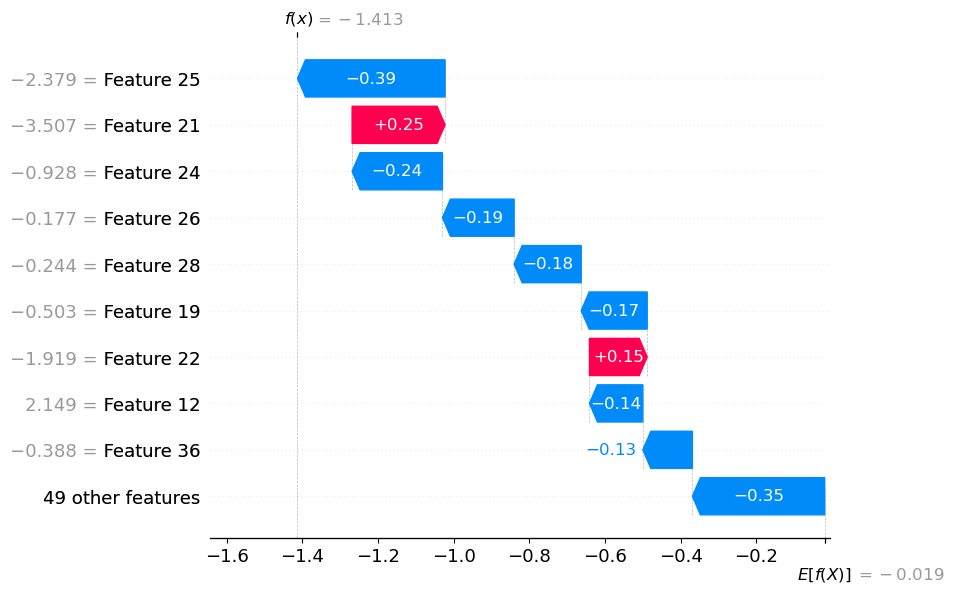

In [5]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

上面的解释显示了每个特征，这些特征都有助于将模型输出从基值（我们传递的训练数据集上的平均模型输出）推送到模型输出。将预测推高的特征显示为红色，将预测推低的特征显示为蓝色。

可视化相同解释的另一种方法是使用力图:

In [6]:
# visualize the first prediction's explanation with a force plot
shap.initjs()
shap.plots.force(shap_values[0])

如果我们采用许多力图解释，如上所示，将它们旋转 90 度，然后水平堆叠，我们可以看到整个数据集的解释(可交互图)：

In [ ]:
# visualize all the training set predictions
shap.plots.force(shap_values)

In [13]:
shap_values.names

AttributeError: 'Explanation' object has no attribute 'names'

In [14]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"Feature 25"], color=shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


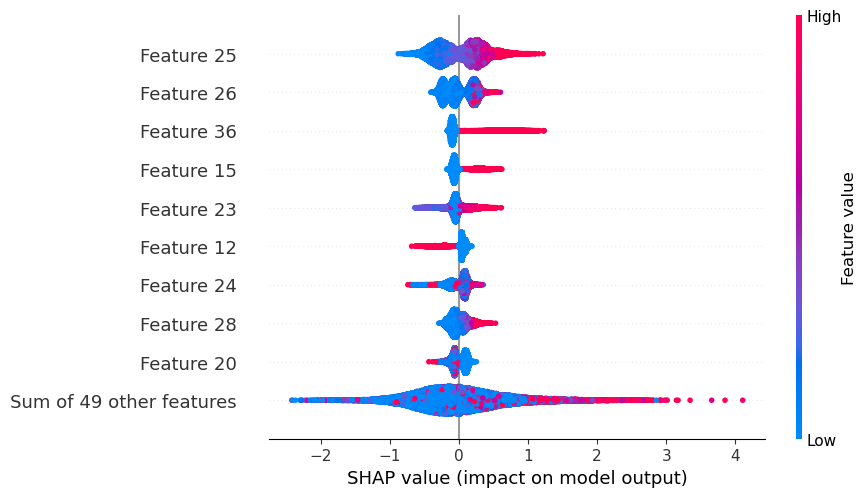

In [15]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

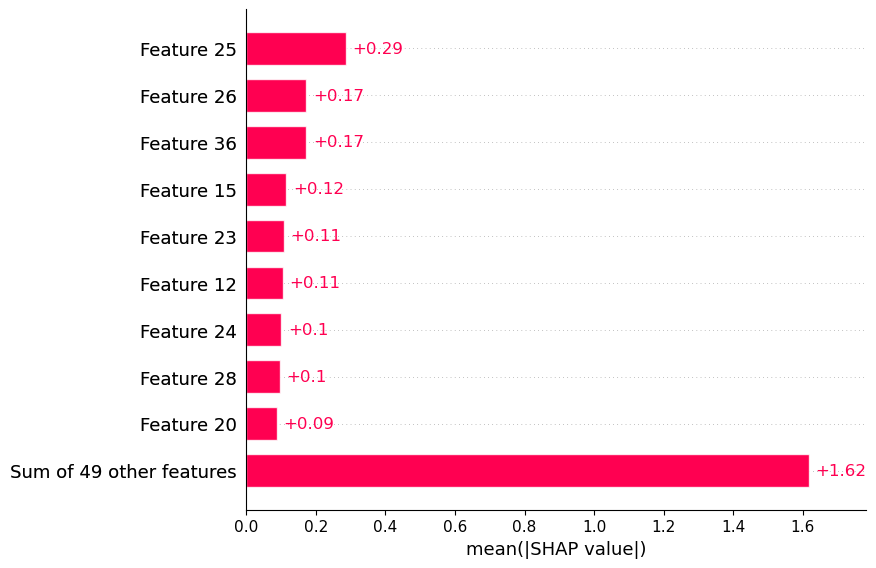

In [16]:
shap.plots.bar(shap_values)